# Vlasov-Poisson 

In this notebook we present a multithreaded version of the Vlasov-Poisson system in 1D1D phase space.
Equations are solved numerically using semi-lagrangian method. The serial version of this code,optimized 
succesively by f2py, numba, pythran and cython is available on Github http://github.com/pnavaro/python-notebooks

I made some tests with multiprocessing library from python but it is not very effective.

In this notebook i translate advection functions in fortran and use openmp directives.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (11,7)

In [3]:
%load_ext fortranmagic
%env CC='gcc-7'
%env FC='gfortran'



env: CC='gcc-7'
env: FC='gfortran'


In [41]:
%%fortran --link fftw3 --f90flags "-O3 -fopenmp -march=native" --extra "-L/usr/local/lib -lgomp"

module bsl_fftw

   use, intrinsic :: iso_c_binding
   implicit none
   include 'fftw3.f03'
   
   contains
   
   recursive function bspline(p, j, x) result(res)
   
      integer :: p, j
      real(8) :: x, w, w1
      real(8) :: res
   
      if (p == 0) then
          if (j == 0) then
              res = 1.0
              return
          else
              res = 0.0
              return
          end if
      else
          w = (x - j) / p
          w1 = (x - j - 1) / p
      end if
   
      res = w * bspline(p-1,j,x)+(1-w1)*bspline(p-1,j+1,x)
   
   end function bspline
   
   subroutine advection(p, n, delta, alpha, axis, df)
   
      integer, intent(in)     :: p
      integer, intent(in)     :: n
      real(8), intent(in)     :: delta
      real(8), intent(in)     :: alpha(0:n-1)
      integer, intent(in)     :: axis
      real(8), intent(inout)  :: df(0:n-1,0:n-1)
            
      !f2py optional , depend(in) :: n=shape(df,0)
   
      real(8),    allocatable :: f(:)
      complex(8), allocatable :: ft(:)
      real(8),    allocatable :: eig_bspl(:)
      real(8),    allocatable :: modes(:)
      complex(8), allocatable :: eigalpha(:)
      integer(8)              :: fwd
      integer(8)              :: bwd
   
      integer                 :: i
      integer                 :: j
      integer                 :: ishift
      real(8)                 :: beta
      real(8)                 :: pi 
            
      pi = 4.0_8 * atan(1.0_8)
  
      allocate(modes(0:n/2))
      allocate(eigalpha(0:n/2))
      allocate(eig_bspl(0:n/2))
      allocate(f(0:n-1))
      allocate(ft(0:n/2))
   
      do i = 0, n/2
         modes(i) = 2.0_8 * pi * i / n
      end do
    
      call dfftw_plan_dft_r2c_1d(fwd, n, f, ft, FFTW_ESTIMATE)
      call dfftw_plan_dft_c2r_1d(bwd, n, ft, f, FFTW_ESTIMATE)
   
      eig_bspl = 0.0   
      do j = 1, (p+1)/2
         eig_bspl = eig_bspl + bspline(p, j-(p+1)/2, 0.0_8) * 2.0 * cos(j * modes)
      end do
   
      eig_bspl = eig_bspl + bspline(p, -(p+1)/2, 0.0_8)
    
      !$OMP PARALLEL DO DEFAULT(FIRSTPRIVATE), SHARED(df,fwd,bwd), NUM_THREADS(1) 
      do i = 0, n-1
   
         ishift = floor(-alpha(i) / delta)
         beta   = -ishift - alpha(i) / delta
         eigalpha = (0.0_8, 0.0_8)
       
         do j=-(p-1)/2, (p+1)/2+1
            eigalpha = eigalpha + bspline(p, j-(p+1)/2, beta) * exp((ishift+j) * (0.0_8,1.0_8) * modes)
         end do     
         
         if (axis == 0) then
           f = df(:,i)
         else
           f = df(i,:)
         end if

         call dfftw_execute_dft_r2c(fwd, f, ft)
         ft = ft * eigalpha / eig_bspl / n
         call dfftw_execute_dft_c2r(bwd, ft, f)
        
         if (axis == 0) then
           df(:,i) = f
         else
           df(i,:) = f
         end if

      end do
      !$OMP END PARALLEL DO     
      
      call dfftw_destroy_plan(fwd)
      call dfftw_destroy_plan(bwd)
      deallocate(modes)
      deallocate(eigalpha)
      deallocate(eig_bspl)
      deallocate(f)
      deallocate(ft)
   
   end subroutine advection


end module bsl_fftw

Writing bsl_fft.F90


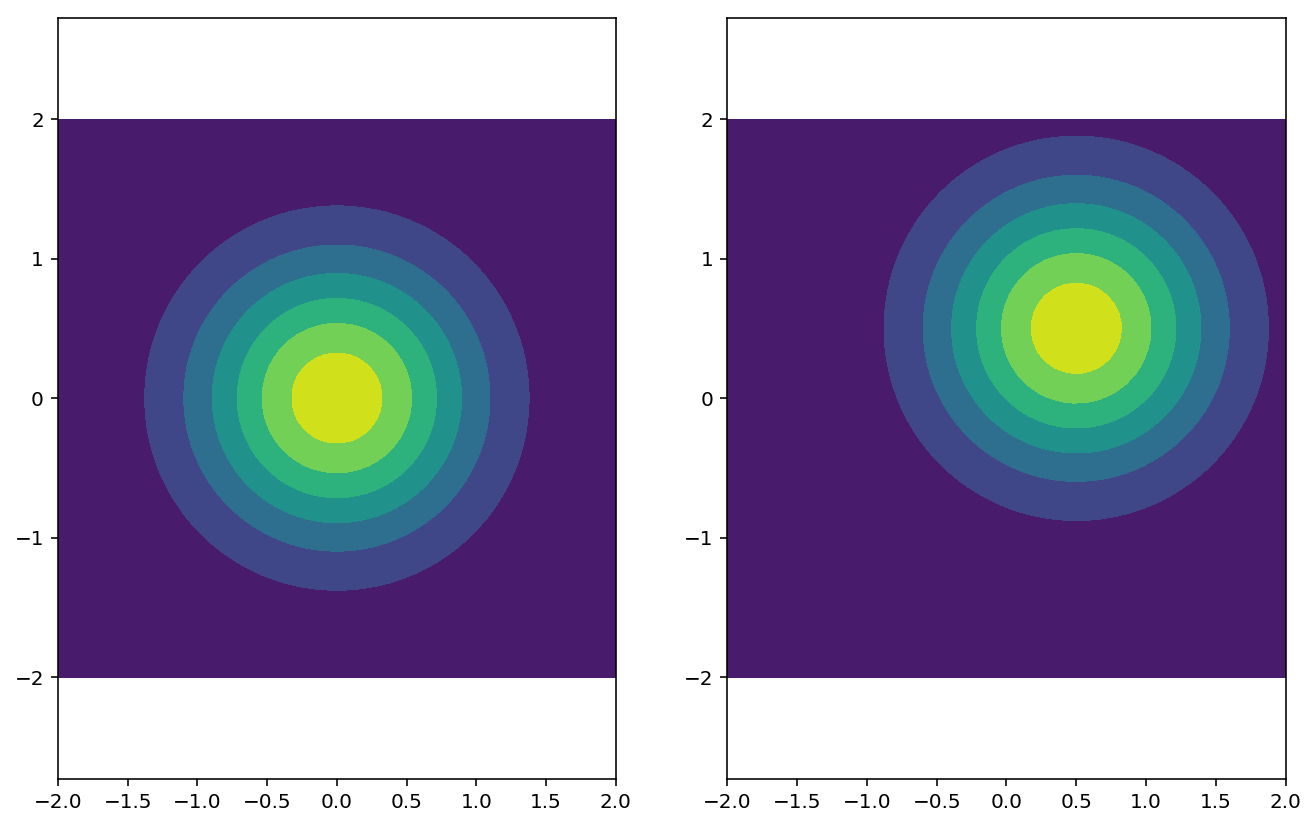

In [35]:
import numpy as np
n = 64
p = 3
alpha = 0.5*np.ones(n)
x, deltax = np.linspace(-2,2,n,retstep=True)
x, y = np.meshgrid(x,x)
df = np.exp(-(x*x+y*y))
df = np.asfortranarray(df)
fig  = plt.figure()
axes = fig.add_subplot(121)
axes.contourf(x,y,df);
axes.set_aspect('equal','datalim')
bsl_fftw.advection(p, deltax, alpha, 0, df)
bsl_fftw.advection(p, deltax, alpha, 1, df)
axes = fig.add_subplot(122)
axes.contourf(x,y,df);
axes.set_aspect('equal','datalim')

In [36]:
%timeit bsl_fftw.advection(p, deltax, alpha, 0, df)

309 µs ± 9.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [37]:
%timeit bsl_fftw.advection(p, deltax, alpha, 1, df)

326 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
import progressbar
from scipy.fftpack import fft, ifft

class VlasovPoisson:
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv):
        
        # Grid
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, endpoint=False, retstep=True)
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, endpoint=False, retstep=True)
        
        # Distribution function
        self.f = np.asfortranarray(np.zeros((nx,nv)))
        
        # Modes for Poisson equation
        self.modes = np.zeros(nx)
        k =  2* np.pi / (xmax - xmin)
        self.modes[:nx//2] = k * np.arange(nx//2)
        self.modes[nx//2:] = - k * np.arange(nx//2,0,-1)
        self.modes += self.modes == 0 # avoid division by zero 
        
    def advection_x(self, dt):
        alpha = dt * self.v
        bsl_fftw.advection(p, self.dx, alpha, 1, self.f)        
            
    def advection_v(self, e, dt):
        alpha = dt * e
        bsl_fftw.advection(p, self.dv, alpha, 0, self.f)
            
    def compute_rho(self):
        return  self.dv * np.sum(self.f, axis=0)
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = fft(rho)/self.modes
        return np.real(ifft(-1j*rhok))
    
    def run(self, f, nstep, dt):
        self.f = f
        nrj = []
        bar = progressbar.ProgressBar()
        self.advection_x(0.5*dt)
        for istep in bar(range(nstep)):
            rho = self.compute_rho()
            e = self.compute_e(rho)
            self.advection_v(e, dt)
            self.advection_x(dt)
            nrj.append( 0.5*np.log(np.sum(e*e)*self.dx))
                
        return nrj

100% (1000 of 1000) |#####################| Elapsed Time: 0:02:59 Time: 0:02:59


 elapsed time : 179.5492 


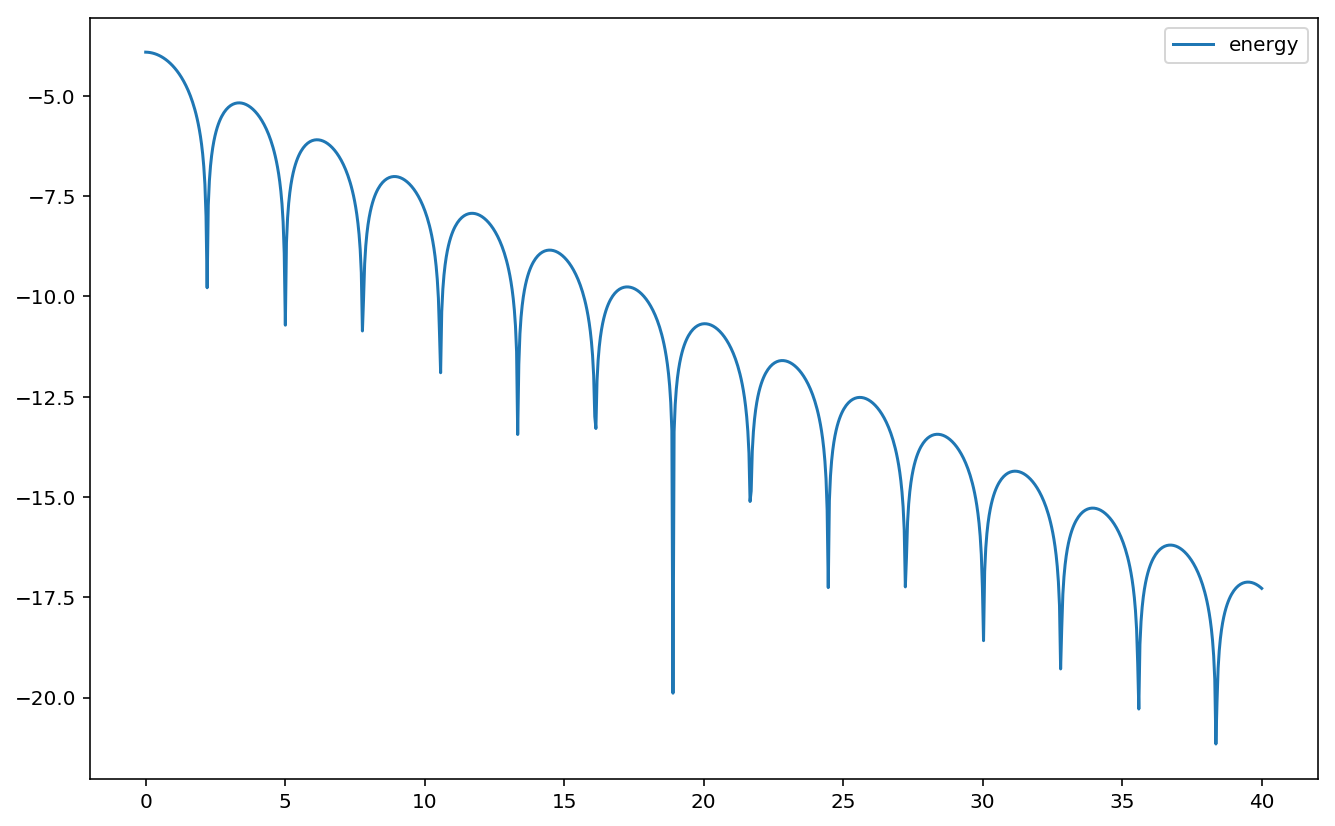

In [39]:
from time import time

elapsed_time = {}
fig, axes = plt.subplots()
# Set grid
nx, nv = 1048, 1048
xmin, xmax = 0.0, 4*np.pi
vmin, vmax = -6., 6.

# Create Vlasov-Poisson simulation
sim = VlasovPoisson(xmin, xmax, nx, vmin, vmax, nv)
# Initialize distribution function
X, V = np.meshgrid(sim.x, sim.v)
eps, kx = 0.01, 0.5
f = (1.0+eps*np.cos(kx*X))/(2.0*np.pi)* np.exp(-0.5*V*V)
f = np.asfortranarray(f)
# Set time domain
nstep = 1000
t, dt = np.linspace(0.0, 40.0, nstep, retstep=True)

# Run simulation
etime = time()
nrj = sim.run(f, nstep, dt)
print(" elapsed time : {0:.4f} ".format(time()-etime))

# Plot energy
axes.plot(t, nrj, label='energy')

    
plt.legend();